(ex_extract_contraction)=

# Extract contraction to matmuls only

In [6]:
%config InlineBackend.figure_formats = ['svg']

import autoray as ar
import cotengra as ctg

Create a random contraction and contraction tree:

In [22]:
inputs, output, shapes, size_dict = ctg.utils.rand_equation(
    n=6,
    reg=5,
    n_out=1,
    n_hyper_in=1,
    n_hyper_out=1,
    seed=42,
)

# square grid contraction:
# inputs, output, shapes, size_dict = ctg.utils.lattice_equation([3, 4])

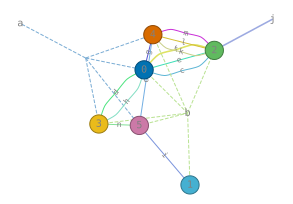

(<Figure size 500x500 with 1 Axes>, <Axes: >)

In [12]:
tree = ctg.array_contract_tree(
    inputs, output, shapes=shapes, optimize="optimal"
)
tree.get_hypergraph().plot()

The high level pairwise contractions can be shown as so:

In [23]:
tree.print_contractions()

(0) cost: 3.2e+01 widths: 2.0,5.0->4.0 type: einsum
inputs: {b}[i],a{b}[i]no->
output: {b}(ano)

(1) cost: 6.4e+01 widths: 4.0,5.0->5.0 type: einsum
inputs: {ba}[n]o,{ab}d[n]h->
output: {ba}o(dh)

(2) cost: 7.7e+02 widths: 5.0,8.6->7.6 type: einsum
inputs: {ba}o[dh],{ab}c[d]efg[h]->
output: {ba}o(cefg)

(3) cost: 1.5e+03 widths: 7.6,7.0->8.6 type: einsum
inputs: {ba}[o]cef[g],{ab}k[g]l[o]m->
output: {ba}cef(klm)

(4) cost: 1.2e+03 widths: 8.6,9.2->2.6 type: tensordot+perm
inputs: [b]a[cefklm],[b]j[cekflm]->
output: (j)a




## Tracing the computational graph

`cotengra` can also further break each `einsum` call down into *only* (batch) matrix multiplies, reshapes and transposes. To extract these we need two things:

1. to trace the contraction with `autoray` lazy arrays.
2. to use `implementation="cotengra"` to avoid using a backends `einsum` impl directly.

In [14]:
variables = [ar.lazy.Variable(shape, backend="numpy") for shape in shapes]

In [15]:
lz = tree.contract(
    variables,
    # make cotengra use its own implementation of einsum/tensordot
    # which breaks things down to bmm / reshape / transpose
    implementation="cotengra",
)

The remaining things are simply autoray related functionality. Visualize the operataions:

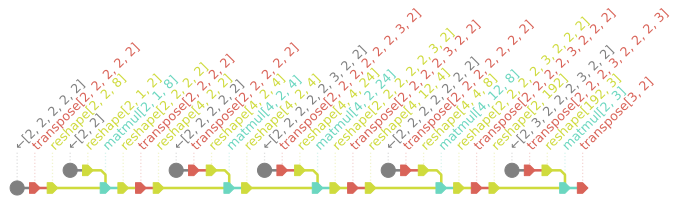

(<Figure size 1049.51x1049.51 with 1 Axes>, <Axes: >)

In [16]:
lz.plot_circuit()

Visualize as text / terminal:

In [17]:
lz.show()

   0 transpose[3, 2]
   1 ╰─matmul[2, 3]
   2   ├─reshape[192, 3]
   3   │ ╰─transpose[2, 2, 2, 3, 2, 2, 2, 3]
   4   │   ╰─←[2, 3, 2, 2, 2, 3, 2, 2]
   5   ╰─reshape[2, 192]
   6     ╰─transpose[2, 2, 2, 2, 3, 2, 2, 2]
   7       ╰─reshape[2, 2, 2, 2, 3, 2, 2, 2]
   8         ╰─matmul[4, 12, 8]
   9           ├─reshape[4, 4, 8]
  10           │ ╰─transpose[2, 2, 2, 2, 2, 2, 2]
  11           │   ╰─←[2, 2, 2, 2, 2, 2, 2]
  12           ╰─reshape[4, 12, 4]
  13             ╰─transpose[2, 2, 2, 2, 3, 2, 2]
  14               ╰─reshape[2, 2, 2, 2, 2, 3, 2]
  15                 ╰─matmul[4, 2, 24]
  16                   ├─reshape[4, 4, 24]
  17                   │ ╰─transpose[2, 2, 2, 2, 2, 2, 3, 2]
  18                   │   ╰─←[2, 2, 2, 2, 2, 3, 2, 2]
  19                   ╰─reshape[4, 2, 4]
  20                     ╰─matmul[4, 2, 4]
  21                       ├─reshape[4, 2, 4]
  22                       │ ╰─transpose[2, 2, 2, 2, 2]
  23                       │   ╰─←[2, 2, 2, 2, 2]
  24

Some preparatory einsums might appear, only for removing initial diagonal indices and trivial indices etc.

## getting the linear form of the contraction

In [18]:
# names of the inputs variables in the contraction
[f"x{id(v)}" for v in variables]

['x139996605978592',
 'x139996605418560',
 'x139996605418080',
 'x139996605426720',
 'x139996605418752',
 'x139996605418272']

In [19]:
# a python source code of the whole contraction
print(lz.get_source())

x139996605419040 = transpose139997039584176(x139996605418272, (1, 2, 0, 3, 4,))
x139996603351968 = reshape139997039578096(x139996605419040, (2, 2, 8,))
del x139996605419040
x139996605426048 = reshape139997039578096(x139996605418560, (2, 1, 2,))
x139996603351488 = matmul139997611038160(x139996605426048, x139996603351968)
del x139996603351968
del x139996605426048
x139996603351872 = reshape139997039578096(x139996603351488, (2, 2, 2, 2,))
del x139996603351488
x139996603351776 = transpose139997039584176(x139996603351872, (0, 1, 3, 2,))
del x139996603351872
x139996603351680 = reshape139997039578096(x139996603351776, (4, 2, 2,))
del x139996603351776
x139996603351584 = transpose139997039584176(x139996605426720, (1, 0, 3, 2, 4,))
x139996603352160 = reshape139997039578096(x139996603351584, (4, 2, 4,))
del x139996603351584
x139996603352256 = matmul139997611038160(x139996603351680, x139996603352160)
del x139996603352160
del x139996603351680
x139996603352544 = reshape139997039578096(x13999660335225

Or access the nodes programmatically:

In [20]:
for node in ar.lazy.ascend(lz):
    print(f"fn: {node.fn}")
    print(f"args: {node.args}")
    print(f"kwargs: {node.kwargs}")
    print()

fn: None
args: None
kwargs: None

fn: <function transpose at 0x7f5399cea7a0>
args: (<LazyArray(fn=None, shape=(2, 2, 2, 2, 2), backend='numpy')>, (1, 2, 0, 3, 4))
kwargs: {}

fn: <function reshape at 0x7f5399cea160>
args: (<LazyArray(fn=transpose, shape=(2, 2, 2, 2, 2), backend='numpy')>, (2, 2, 8))
kwargs: {}

fn: None
args: None
kwargs: None

fn: <function reshape at 0x7f5399cea160>
args: (<LazyArray(fn=None, shape=(2, 2), backend='numpy')>, (2, 1, 2))
kwargs: {}

fn: <built-in function matmul>
args: (<LazyArray(fn=reshape, shape=(2, 1, 2), backend='numpy')>, <LazyArray(fn=reshape, shape=(2, 2, 8), backend='numpy')>)
kwargs: {}

fn: <function reshape at 0x7f5399cea160>
args: (<LazyArray(fn=matmul, shape=(2, 1, 8), backend='numpy')>, (2, 2, 2, 2))
kwargs: {}

fn: <function transpose at 0x7f5399cea7a0>
args: (<LazyArray(fn=reshape, shape=(2, 2, 2, 2), backend='numpy')>, (0, 1, 3, 2))
kwargs: {}

fn: <function reshape at 0x7f5399cea160>
args: (<LazyArray(fn=transpose, shape=(2, 2, 2, 2)